In [1]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
import random
# random.seed(10)
from hyperopt import fmin, rand, hp, Trials, tpe
rstate = np.random.default_rng(42)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

datasets_dir = "../../data"
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

## Loading training, testing and validation data:

In [2]:
split = "secondary"

data_train = pd.read_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
data_test = pd.read_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
data_val = pd.read_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

# data_train["geomean_Km"] = np.log10(data_train["geomean_Km"])
# data_test["geomean_Km"] = np.log10(data_test["geomean_Km"])

data_train["log10_Km"] = np.log10(data_train["Km"])
data_test["log10_Km"] = np.log10(data_test["Km"])
data_val["log10_Km"] = np.log10(data_val["Km"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_val.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(250, 47, 21)

In [3]:
train_indices = list(np.load(join(datasets_dir, "splits", split, "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join(datasets_dir, "splits", split, "CV_test_indices_Seed plants.npy"), allow_pickle = True))

In [4]:
data_test = data_test[~data_test['GNN FP'].isnull()]

nan_rows = data_train[data_train['GNN FP'].apply(lambda x: not isinstance(x, np.ndarray))]

# Get the indices of these rows
indices_with_nan = nan_rows.index.tolist()
# indices_with_nan.reverse()
print(indices_with_nan)

for ind, sub_list in enumerate(train_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(train_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                train_indices[ind][i] = elem-1

for ind, sub_list in enumerate(test_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(test_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                test_indices[ind][i] = elem-1  

data_train = data_train[data_train['GNN FP'].apply(lambda x: isinstance(x, np.ndarray))]
data_train.reset_index(inplace=True, drop=True)

[]


## 1. Training a model with enzyme and main substrate information (ESM-2/MACCS) + Temperature + pH :

#### (a) Creating input matrices:

In [5]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train['GNN FP'])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test['GNN FP'])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [6]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [7]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 7.0, 'min_child_weight': 1.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [8]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [9]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_gnn_fp.npy"), np.array(R2))

[0.5199203485132662, 0.7397811102111977, 0.15488622591484363, 0.7461384530061692, 0.27289070177382757]
[0.0006448718224672728, 0.00017930716023550986, 0.0003633598808735722, 0.0003032771303576554, 0.00032528913955772625]
[0.11908387610274718, 0.5023846416894112, -0.07598337442643466, 0.28409048905391454, -0.0392395475560916]
[0.00015732395527509737, 7.331573723915201e-05, 0.000146258672630747, 0.00012001498738810819, 9.825489060540186e-05]
[4.260747304429911e-05, 1.5815478269379325e-05, 1.604883332141598e-05, 2.438261311966666e-05, 1.388529232152446e-05]


In [10]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],20) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_gnn_fp.npy"), test_Y)

0.05739271223071115 0.0002711852 -0.106 9.88564e-05 2.14867e-05


In [11]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [12]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train['GNN FP'])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test['GNN FP'])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [13]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, "xgboost_train_and_test.pkl"), "wb"))

(0.9898172292154614, 9.494155316317775e-40) 3.763675647129997e-05 0.9786893049370851


In [14]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 20.0
f1: 6.0
f2: 12.0
f3: 1.0
f4: 4.0
f8: 1.0
f10: 2.0
f11: 1.0
f13: 3.0
f18: 1.0
f19: 1.0
f24: 2.0
f25: 1.0
f27: 1.0
f31: 1.0
f33: 2.0
f38: 1.0
f39: 2.0
f47: 1.0
f48: 2.0
f49: 2.0
f50: 2.0
f53: 1.0
f58: 1.0
f63: 1.0
f64: 2.0
f72: 2.0
f78: 1.0
f81: 1.0
f84: 1.0
f87: 2.0
f95: 2.0
f98: 1.0
f100: 1.0
f101: 1.0
f106: 2.0
f107: 1.0
f116: 1.0
f124: 2.0
f126: 1.0
f127: 5.0
f130: 1.0
f134: 5.0
f140: 1.0
f143: 2.0
f147: 2.0
f150: 1.0
f154: 1.0
f160: 1.0
f164: 1.0
f165: 1.0
f169: 1.0
f170: 2.0
f172: 7.0
f174: 1.0
f178: 1.0
f180: 4.0
f181: 1.0
f190: 1.0
f191: 1.0
f192: 1.0
f196: 1.0
f197: 1.0
f207: 1.0
f208: 2.0
f223: 1.0
f228: 4.0
f238: 1.0
f243: 1.0
f248: 1.0
f256: 8.0
f257: 4.0
f260: 3.0
f265: 2.0
f267: 1.0
f270: 1.0
f278: 1.0
f283: 1.0
f285: 1.0
f287: 2.0
f290: 2.0
f292: 1.0
f297: 1.0
f299: 1.0
f306: 1.0
f307: 1.0
f308: 2.0
f310: 2.0
f313: 1.0
f314: 1.0
f316: 1.0
f319: 2.0
f321: 1.0
f323: 1.0
f325: 2.0
f327: 1.0
f330: 1.0
f333: 1.0
f335: 1.0
f336: 2.0
f339: 1.0
f345: 2.0
f352: 1.

##### Validating model:

In [15]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [16]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [17]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_val_pred_xgboost_esm2_gnn_fp.npy"), y_val_pred)

(-0.12896006031971574, 0.5774472064943161) 0.0021231357894824954 -0.16332911626488422 0.000817117984371571 0.00013026854543598198


In [18]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.cm as cmx

# plt.scatter(val_Y,y_val_pred, c='blue', edgecolors='black',s=15)
    
# plt.xlim(-6,2)
# plt.ylim(-6,2)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel('Real value', fontsize=15)
# plt.ylabel('Estimated value', fontsize=15)
# plt.title('Predictions', fontsize=15)
# plt.axline((1, 1), slope=1, c='red')
# plt.show()

In [19]:
# data_combined = pd.concat([data_train, data_test],ignore_index=True)

In [20]:
# def calculate_identity_ignore_gaps(seq1, seq2):
#     identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
#     pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
#     return pid

# from Bio import Align
# from Bio.Align import substitution_matrices

# data_val["max_identity"] = np.nan

# aligner=Align.PairwiseAligner()
# aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
# aligner.mode = "global"
# aligner.extend_gap_score = -0.5
# aligner.open_gap_score = -10

# for i in data_val.index:
#     identities = []
#     for j in data_combined.index:
#         seq1 = str(data_val["Sequence"][i])
#         seq2 = str(data_combined["Sequence"][j])
#         if 'U' in seq1:
#             seq1 = seq1.replace('U', 'C')
#         if 'U' in seq2:
#             seq2 = seq2.replace('U', 'C')
#         alignments = aligner.align(seq1, seq2)
#         identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
#     data_val["max_identity"][i] = max(identities)

In [21]:
# data_val["max_identity"] = data_val["max_identity"]*100

In [22]:
# import matplotlib.pyplot as plt
# import sklearn.metrics as sk
# import math

# fig, ax = plt.subplots(figsize= (10,8))
# plt.rcParams.update({'font.size': 28})

# splits = ["0-40%", "40-80%", "80-99%", "99-100%"]
# lower_bounds = [0,40,80,99]
# upper_bounds = [40,80,99,100]

# points1 = []
# points2 = []
# n_points1, n_points2 = [], []

# for i, split in enumerate(splits):

#     lb, ub = lower_bounds[i], upper_bounds[i]
    
#     help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
#     y_true = np.array([10**x for x in help_df["log10_Km"]])
#     y_pred = np.array([10**x for x in help_df["Estimate Km"]])
#     n_km = len(y_pred)
#     R2 =  sk.r2_score(y_true, y_pred)
#     abs_error = abs(y_true - y_pred)
#     rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
#     print(len(y_true))
#     print(split, R2, rmse)
#     points1.append(R2)
#     points2.append(rmse)
#     n_points1.append(n_km)


# ticks2 = np.array(range(len(splits)))
# labs = splits
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((-0.1,2.5))
# # plt.xlim((-0.2, 3.2))
# plt.legend(loc = "lower right", fontsize=20)
# plt.ylabel('RMSE')
# plt.xlabel('Enzyme sequence identity')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


# plt.plot([0,1,2,3], points2, c= "black", linewidth=2)

# for i, split in enumerate(splits):
#     points1.append(R2)
    
#     if i ==0:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

#     else:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
# plt.savefig(join("..","..", "data", split, "sequence_identity.png"))
# plt.show()

In [23]:
# EC_km_pred =[[] for _ in range(6)]
# EC_km =[[] for _ in range(6)]
# for ind in data_val.index:
#     try:
#         EC = int(data_val["ECs"][ind][0][0])
#         EC_km[EC-1].append(data_val["log10_Km"][ind])
#         EC_km_pred[EC-1].append(data_val["Estimate Km"][ind])
#     except IndexError:
#         pass

In [24]:
# fig, ax = plt.subplots(figsize= (8,8))
# plt.rcParams.update({'font.size': 28})

# classes = [str(i) for i in range(1,7)]

# for i in range(len(EC_km)):
    
#     circle = plt.Circle((np.mean(EC_km[i]), np.mean(EC_km_pred[i]) ),
#                         np.sqrt(len(EC_km_pred[i]))/300, color='navy', fill = True)
#     ax.add_artist(circle)
#     if i ==5:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_km[i])+0.01, np.mean(EC_km_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
#     else:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_km[i])+0.03, np.mean(EC_km_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# # ticks2 = [0.2, 0.6,1,1.4,1.8]
# # labs = ticks2
# # ax.set_xticks(ticks2)
# # ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# # ax.tick_params(axis='x', length=0, rotation = 0)

# # ax.set_yticks(ticks2)
# # ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# # ax.tick_params(axis='y', length=0, rotation = 0)

# plt.ylim((-6,-1))
# plt.xlim((-6, -1))
# plt.legend(loc = "upper left", fontsize=20)
# plt.xlabel('mean measured \n $k_{m}$ value on $\log_{10}$-scale')
# plt.ylabel('mean predicted \n $k_{m}$ value on $\log_{10}$-scale')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)
# plt.axline((1, 1), slope=1, c='grey', alpha = 0.3, linestyle='dashed')
# plt.savefig(join("..", "..", "data", split, "EC_classes_mean_km.png"))
# plt.show()

In [25]:
# import scipy

# train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
# test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["substrate_sim"] = max_sim

# data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
# data_val["substrate_sim"] = data_val["substrate_sim"]/np.max(data_val["substrate_sim"])

In [26]:
# data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["substrate_sim"]

In [27]:
# data_val.describe()

In [28]:
# import matplotlib.pyplot as plt
# import math
# import scipy as sci
# help_df = data_val

# sim_bins_lb = [0.0, 0.4, 0.8]
# sim_bins_ub = [0.4, 0.8, 1]
# r2_scores, n_points, pearson_r, rmse = [], [], [], []
# for i in range(len(sim_bins_lb)):
#     help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
#     pred = np.array([10**x for x in help_df2["log10_Km"]])
#     true = np.array([10**x for x in help_df2["Estimate Km"]])
#     r2_scores.append(sk.r2_score(true, pred))
#     pearson_r.append(sci.stats.pearsonr(true, pred)[0])
#     rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
#     n_points.append(len(pred))
#     print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

# plt.rcParams.update({'font.size': 24})

# fig, ax = plt.subplots(figsize= (8,6))

# for i in range(len(sim_bins_lb)):    
#     plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
#     ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
# plt.xlabel('Reaction similarity score')
# plt.ylabel('RMSE')
# ax.yaxis.set_label_coords(-0.2, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.23)

# ticks2 = np.array(range(len(sim_bins_lb)))
# labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((0.5,2))
# #plt.xlim((-0.5, 3.2))

# # plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
# #plt.savefig(join("..","..", "data", split, "figures", "Reaction_Similarity_Score.eps"))
# plt.show()

## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH :

#### (a) Creating input matrices:

In [29]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [30]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [31]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.0}


#### (c) Training and validating model:

In [32]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [33]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_diff_fp.npy"), np.array(R2))

[0.25163572945089574, 0.5312724270259473, 0.15246479602544866, 0.6832609711095411, 0.34962081094382874]
[0.0006786740398272628, 0.0002244521578691847, 0.00036813684228527183, 0.00029220453191680174, 0.0003232726661499139]
[0.024313644481934404, 0.2202667018656851, -0.10446047243472201, 0.3354116828441034, -0.02639495282675286]
[0.00017330047564691344, 0.00010056511180766795, 0.00015888646634566343, 0.00012395488748220444, 0.00010040270816391578]
[5.6375869513102634e-05, 2.094530420414715e-05, 1.824523515396657e-05, 1.8697746609596684e-05, 1.7521793269381112e-05]


In [34]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_diff_fp.npy"), test_Y)

-0.131 0.0002824538 -0.2 0.0001229285 2.81244e-05


In [35]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [36]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [37]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, "xgboost_train_and_test.pkl"), "wb"))

(0.9704556244220978, 1.9897995979214434e-29) 6.78248971390909e-05 0.9307927608561934


##### Validating model:

In [38]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [39]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [40]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_val_pred_xgboost_esm2_diff_fp.npy"), y_val_pred)

(-0.11331467596135145, 0.6248016254891205) 0.0021301592652876095 -0.17103858865173893 0.0008263272891457533 0.0001334632171679235


## 3. Training a model with enzyme, main substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH :

#### (a) Creating input matrices:

In [41]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [42]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [43]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 7.0, 'min_child_weight': 1.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [44]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [45]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(R2))

[0.5225224727767662, 0.7371180523524636, 0.6200187780030267, 0.6625690096190502, 0.2507823521620893]
[0.0006471173330063183, 0.0001790881734490074, 0.00030691216714537437, 0.00029295495397388844, 0.0003268480129077303]
[0.11293831242005536, 0.5035993689222793, 0.23235606402865128, 0.331993788382725, -0.04922404736702912]
[0.00015950546549556015, 7.302956311995039e-05, 0.00014022775598690384, 0.00013005897687073668, 0.00010071470725794615]
[5.457984026167782e-05, 1.8181977795051037e-05, 1.5959748806018074e-05, 3.2289567517589565e-05, 1.548533951481953e-05]


In [46]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_gnn_fp_diff_fp.npy"), test_Y)

0.187 0.0002662701 -0.067 9.56062e-05 2.10116e-05


In [47]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [48]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [49]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, "xgboost_train_and_test.pkl"), "wb"))

(0.9879404876107705, 4.1875416995798056e-38) 4.272577710033838e-05 0.9725366711170059


##### Validating model:

In [50]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [51]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [52]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_val_pred_xgboost_esm2_gnn_fp_diff_fp.npy"), y_val_pred)

(-0.011727499930345248, 0.9597615435492478) 0.002110038730424687 -0.14902084995832499 0.0008005895758746664 0.00013560780601986445


## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [53]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [54]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [55]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 9.0, 'min_child_weight': 2.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [56]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [57]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2.npy"), np.array(R2))

[0.18133704014523727, 0.4605864162445504, 0.6194010538828846, 0.6873885917898301, 0.24077568299301016]
[0.0006819115555389379, 0.00024684210388351604, 0.00034262504032759044, 0.0003019401882707266, 0.0003250064035092188]
[0.014982702034150197, 0.056945070483301996, 0.043313135142012404, 0.2903884904144556, -0.03743375233537871]
[0.00017179299141963683, 0.00010203952313152671, 0.00013634451312192832, 0.00012400518170774168, 9.956464636236466e-05]
[5.7247981708371146e-05, 1.9615857117036764e-05, 2.026708905028888e-05, 2.1326362483102093e-05, 2.0485415695111245e-05]


In [58]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2.npy"), test_Y)

-0.154 0.0002806407 -0.185 0.0001187232 2.36874e-05


In [59]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [60]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [61]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, "xgboost_train_and_test.pkl"), "wb"))

(0.9581270132820607, 4.4731094011457e-26) 8.138884238646844e-05 0.9003441082363031


In [62]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 3.0
f1: 2.0
f7: 2.0
f8: 2.0
f10: 2.0
f12: 1.0
f14: 1.0
f15: 1.0
f20: 1.0
f21: 1.0
f22: 1.0
f23: 1.0
f27: 1.0
f34: 1.0
f43: 4.0
f44: 1.0
f47: 1.0
f49: 2.0
f50: 1.0
f51: 1.0
f52: 2.0
f58: 2.0
f59: 1.0
f64: 5.0
f65: 1.0
f81: 1.0
f82: 1.0
f84: 4.0
f91: 1.0
f93: 1.0
f104: 1.0
f107: 2.0
f108: 1.0
f127: 1.0
f130: 1.0
f132: 1.0
f138: 3.0
f143: 2.0
f147: 1.0
f154: 1.0
f158: 1.0
f162: 1.0
f168: 4.0
f169: 4.0
f170: 5.0
f172: 8.0
f174: 1.0
f178: 2.0
f179: 3.0
f182: 1.0
f185: 1.0
f188: 1.0
f189: 1.0
f192: 2.0
f194: 1.0
f196: 2.0
f201: 3.0
f202: 1.0
f209: 3.0
f216: 2.0
f217: 1.0
f218: 5.0
f222: 3.0
f228: 6.0
f230: 1.0
f233: 1.0
f234: 1.0
f236: 1.0
f238: 2.0
f243: 1.0
f251: 1.0
f254: 1.0
f258: 1.0
f259: 2.0
f260: 5.0
f261: 3.0
f262: 1.0
f263: 6.0
f267: 7.0
f269: 1.0
f270: 3.0
f273: 3.0
f277: 3.0
f278: 1.0
f279: 2.0
f287: 1.0
f288: 1.0
f289: 1.0
f292: 1.0
f296: 2.0
f299: 1.0
f304: 1.0
f305: 3.0
f306: 2.0
f310: 3.0
f312: 1.0
f318: 4.0
f319: 1.0
f324: 1.0
f325: 3.0
f329: 1.0
f330: 2.0
f336:

#### (e) Validating model:

In [63]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_val_pred_xgboost_esm2.npy"), y_val_pred)

(-0.13859934428711476, 0.5490704009607509) 0.0021304165891205843 -0.1713215293161754 0.0008184375400276341 0.00013239175408217034


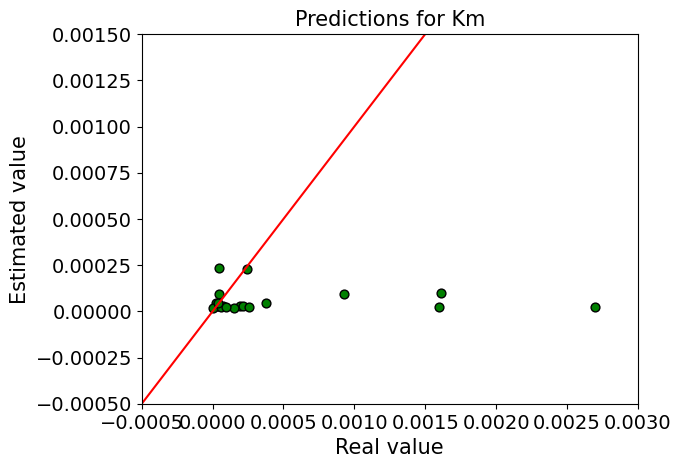

In [64]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter([10**x for x in val_Y],[10**x for x in y_val_pred],c='green', edgecolors='black',s=40)
    
plt.xlim(-0.0005,0.003)
plt.ylim(-0.0005,0.0015)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.title('Predictions for Km', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

## 5. Training a model with main substrate information (MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [65]:
train_X = np.array(list(data_train['GNN FP']))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test['GNN FP']))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [66]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [67]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 4.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.2}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 9.0, 'min_child_weight': 2.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [68]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [69]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_gnn_fp.npy"), np.array(R2))

[0.9150233773150938, 0.727115274764449, 0.6832660383167478, 0.942835617043557, 0.3728122859618907]
[0.0005714300895578365, 0.00024227053251710867, 0.0002572082349062447, 0.00017112006505593983, 0.00030895211464393484]
[0.30830606522076465, 0.09155278327290406, 0.46086025360835736, 0.7720809210123359, 0.06252675514915307]
[0.00015259650989874027, 0.0001019345066447799, 0.00012763689601208905, 8.361454911547321e-05, 0.0001024334398649565]
[4.5397938499862486e-05, 2.2649708011623023e-05, 2.2286481231812147e-05, 1.853626208896586e-05, 1.1530124329893357e-05]


In [70]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_gnn_fp.npy"), test_Y)

0.613 0.0002412631 0.124 0.0001022423 3.60267e-05


In [71]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [72]:
train_X = np.array(list(data_train["GNN FP"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["GNN FP"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [73]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, "xgboost_train_and_test.pkl"), "wb"))

(0.941589484311983, 6.721642204715581e-23) 9.096460523373047e-05 0.8755146871518645


In [74]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 66.0
f1: 26.0
f2: 19.0
f3: 27.0
f4: 4.0
f5: 18.0
f6: 4.0
f7: 18.0
f8: 1.0
f9: 2.0
f10: 45.0
f11: 99.0
f12: 37.0
f13: 2.0
f14: 3.0
f15: 15.0
f17: 1.0
f18: 7.0
f19: 5.0
f21: 42.0
f22: 7.0
f23: 21.0
f24: 5.0
f25: 1.0
f26: 8.0
f28: 4.0
f29: 8.0
f30: 79.0
f31: 26.0
f32: 24.0
f33: 13.0
f35: 1.0
f37: 4.0
f38: 95.0
f40: 6.0
f41: 21.0
f44: 40.0
f45: 30.0
f46: 35.0
f47: 2.0
f49: 56.0
f50: 263.0
f51: 341.0


#### (e) Validating model:

In [75]:
val_X = np.array(list(data_val["GNN FP"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE,MedAE)
np.save(join("..", "..", "data", split, "y_val_pred_xgboost_gnn_fp.npy"), y_val_pred)

(0.007081966601030266, 0.9756949089461888) 0.0020824451663072046 -0.11916521869578167 0.0007773450188320411 0.00013619331012523593


## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [76]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [77]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [78]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 9.0, 'min_child_weight': 2.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.2}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 8.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 9.0, 'min_child_weight': 2.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.2}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 8.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.4, 'reg_lambda': 0.0}

#### (c) Training and validating model:

In [79]:

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [80]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_diff_fp.npy"), np.array(R2))

[0.43359935140569233, 0.5174579430402009, 0.5626889988189872, 0.6763290718055428, 0.27941382606950677]
[0.0006696955477786594, 0.00023235662998863404, 0.0003083341435700792, 0.00026544316911040355, 0.0003110951648906687]
[0.049958491232671376, 0.1643803407207478, 0.2252263349705853, 0.4515691008727999, 0.04947605841428726]
[0.00015746801213424263, 9.819079353562471e-05, 0.00013790364870032177, 0.00012661519789385517, 0.00011051542509979001]
[3.2607607817127814e-05, 1.971574405443267e-05, 2.2424220271076285e-05, 2.3408648747361282e-05, 2.1673720055069048e-05]


In [81]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_diff_fp.npy"), test_Y)

-0.067 0.0002713714 -0.108 0.0001092638 3.88294e-05


In [82]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [83]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [84]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, "xgboost_train_and_test.pkl"), "wb"))

(0.8850182643308198, 1.5212354392128966e-16) 0.00017847538730316948 0.5207855522826073


In [85]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f7: 2.0
f28: 27.0
f29: 2.0
f36: 11.0
f43: 9.0
f60: 18.0
f61: 21.0
f74: 2.0
f75: 48.0
f88: 11.0
f95: 56.0
f106: 6.0
f115: 15.0
f116: 46.0
f124: 92.0
f125: 81.0
f129: 35.0
f134: 17.0
f137: 1.0
f138: 52.0
f144: 4.0
f146: 2.0
f157: 22.0
f158: 5.0
f159: 3.0
f169: 3.0
f178: 34.0
f181: 56.0
f190: 81.0
f191: 67.0
f200: 64.0
f201: 30.0
f207: 4.0
f212: 7.0
f246: 38.0
f254: 7.0
f261: 6.0
f263: 3.0
f311: 4.0
f312: 5.0
f334: 70.0
f374: 5.0
f412: 68.0
f443: 2.0
f515: 5.0
f563: 5.0
f570: 2.0
f571: 17.0
f618: 4.0
f648: 7.0
f682: 67.0
f728: 21.0
f772: 1.0
f776: 28.0
f778: 60.0
f780: 14.0
f783: 23.0
f798: 92.0
f808: 6.0
f818: 61.0
f823: 6.0
f836: 2.0
f837: 5.0
f844: 5.0
f847: 1.0
f861: 2.0
f880: 1.0
f883: 6.0
f888: 21.0
f889: 31.0
f909: 40.0
f926: 10.0
f936: 4.0
f938: 3.0
f939: 56.0
f1009: 46.0
f1018: 3.0
f1019: 32.0
f1024: 12.0
f1025: 9.0
f1032: 1.0
f1035: 4.0
f1040: 1.0
f1041: 1.0
f1048: 57.0
f1049: 27.0
f1072: 19.0
f1074: 18.0
f1077: 51.0
f1082: 6.0
f1088: 11.0
f1089: 7.0
f1093: 13.0
f1096: 

#### (e) Validating model:

In [86]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_val_pred_xgboost_diff_fp.npy"), y_val_pred)

(-0.025231412809050374, 0.9135502566167617) 0.002111440305446125 -0.15054781129724626 0.0008550800401415818 0.00014399568168327028


## 7. Training a model with reaction and main substrate information (diff-fp/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [87]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [88]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [89]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 8.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 5.0, 'min_child_weight': 2.0, 'num_rounds': 500, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 11.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [90]:

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [91]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(R2))

[0.4396689810814537, 0.7743697318177175, 0.7269163802147918, 0.9023453661673277, 0.05304541490833936]
[0.0006546141301145176, 0.00016704962866294771, 0.00024806543021739557, 0.00019641828086581212, 0.00033981530402159694]
[0.09226619721632823, 0.5680936989066906, 0.4985078901970298, 0.6997087905379633, -0.13412886965673265]
[0.00017108079114021751, 7.110928105151907e-05, 0.0001274092313052873, 9.532241112066016e-05, 0.00011657435040702177]
[5.2124301597887185e-05, 1.601137593623368e-05, 2.189078157229098e-05, 2.720346082121788e-05, 2.2699404507001822e-05]


In [92]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],20) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_gnn_fp_diff_fp.npy"), test_Y)

0.27222701152450357 0.0002627606 -0.039 0.0001006426 2.18101e-05


In [93]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [94]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [95]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, "xgboost_train_and_test.pkl"), "wb"))

(0.9518546955559481, 9.681199131833892e-25) 8.248612992253333e-05 0.8976388650347142


In [96]:
importances = bst.get_score()
print(len(data_train["difference_fp"][1]))
print(len(data_train["GNN FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

2048
50
f4: 3.0
f6: 2.0
f7: 2.0
f28: 6.0
f29: 2.0
f43: 6.0
f61: 13.0
f71: 8.0
f74: 22.0
f75: 8.0
f88: 1.0
f94: 12.0
f95: 9.0
f106: 8.0
f116: 14.0
f124: 16.0
f125: 4.0
f134: 7.0
f137: 11.0
f138: 6.0
f146: 2.0
f148: 1.0
f157: 1.0
f158: 3.0
f178: 6.0
f181: 7.0
f190: 17.0
f191: 14.0
f193: 3.0
f200: 11.0
f201: 9.0
f212: 1.0
f231: 1.0
f241: 2.0
f246: 14.0
f254: 1.0
f255: 8.0
f270: 3.0
f312: 5.0
f334: 11.0
f335: 1.0
f374: 3.0
f377: 1.0
f406: 12.0
f477: 15.0
f512: 1.0
f515: 5.0
f529: 2.0
f570: 18.0
f571: 4.0
f618: 2.0
f648: 3.0
f682: 8.0
f706: 5.0
f728: 10.0
f756: 1.0
f768: 5.0
f776: 9.0
f778: 5.0
f780: 1.0
f782: 5.0
f783: 3.0
f786: 1.0
f798: 4.0
f816: 12.0
f823: 16.0
f833: 3.0
f837: 6.0
f844: 9.0
f863: 8.0
f883: 6.0
f888: 2.0
f889: 8.0
f902: 1.0
f909: 1.0
f910: 5.0
f936: 1.0
f939: 5.0
f944: 9.0
f945: 1.0
f952: 1.0
f1005: 10.0
f1009: 6.0
f1018: 1.0
f1019: 1.0
f1024: 9.0
f1025: 8.0
f1033: 2.0
f1038: 1.0
f1041: 1.0
f1043: 7.0
f1048: 21.0
f1049: 1.0
f1072: 1.0
f1074: 3.0
f1077: 5.0
f1082: 2.0
f10

[('f2051', 67.72605895996094), ('f2099', 38.1895751953125), ('f1310', 26.212127685546875), ('f2098', 19.579893112182617), ('f1615', 18.143878936767578), ('f1869', 12.39501953125), ('f1162', 11.302261352539062), ('f2080', 10.637908935546875), ('f2085', 8.921989440917969), ('f823', 8.906108856201172), ('f2053', 8.751968383789062), ('f2049', 7.942471027374268), ('f1139', 7.913815975189209), ('f2077', 7.4472527503967285), ('f2086', 7.420047283172607), ('f1816', 7.144686222076416), ('f2097', 7.081462860107422), ('f2092', 5.813124656677246), ('f1490', 5.065102577209473), ('f2081', 4.624008655548096), ('f2048', 4.39804220199585), ('f181', 4.236781120300293), ('f88', 4.143310546875), ('f2093', 4.034087181091309), ('f1009', 3.570812940597534), ('f246', 3.4767794609069824), ('f191', 3.386826992034912), ('f2089', 3.2419493198394775), ('f2069', 3.238166332244873), ('f334', 2.8730034828186035)]


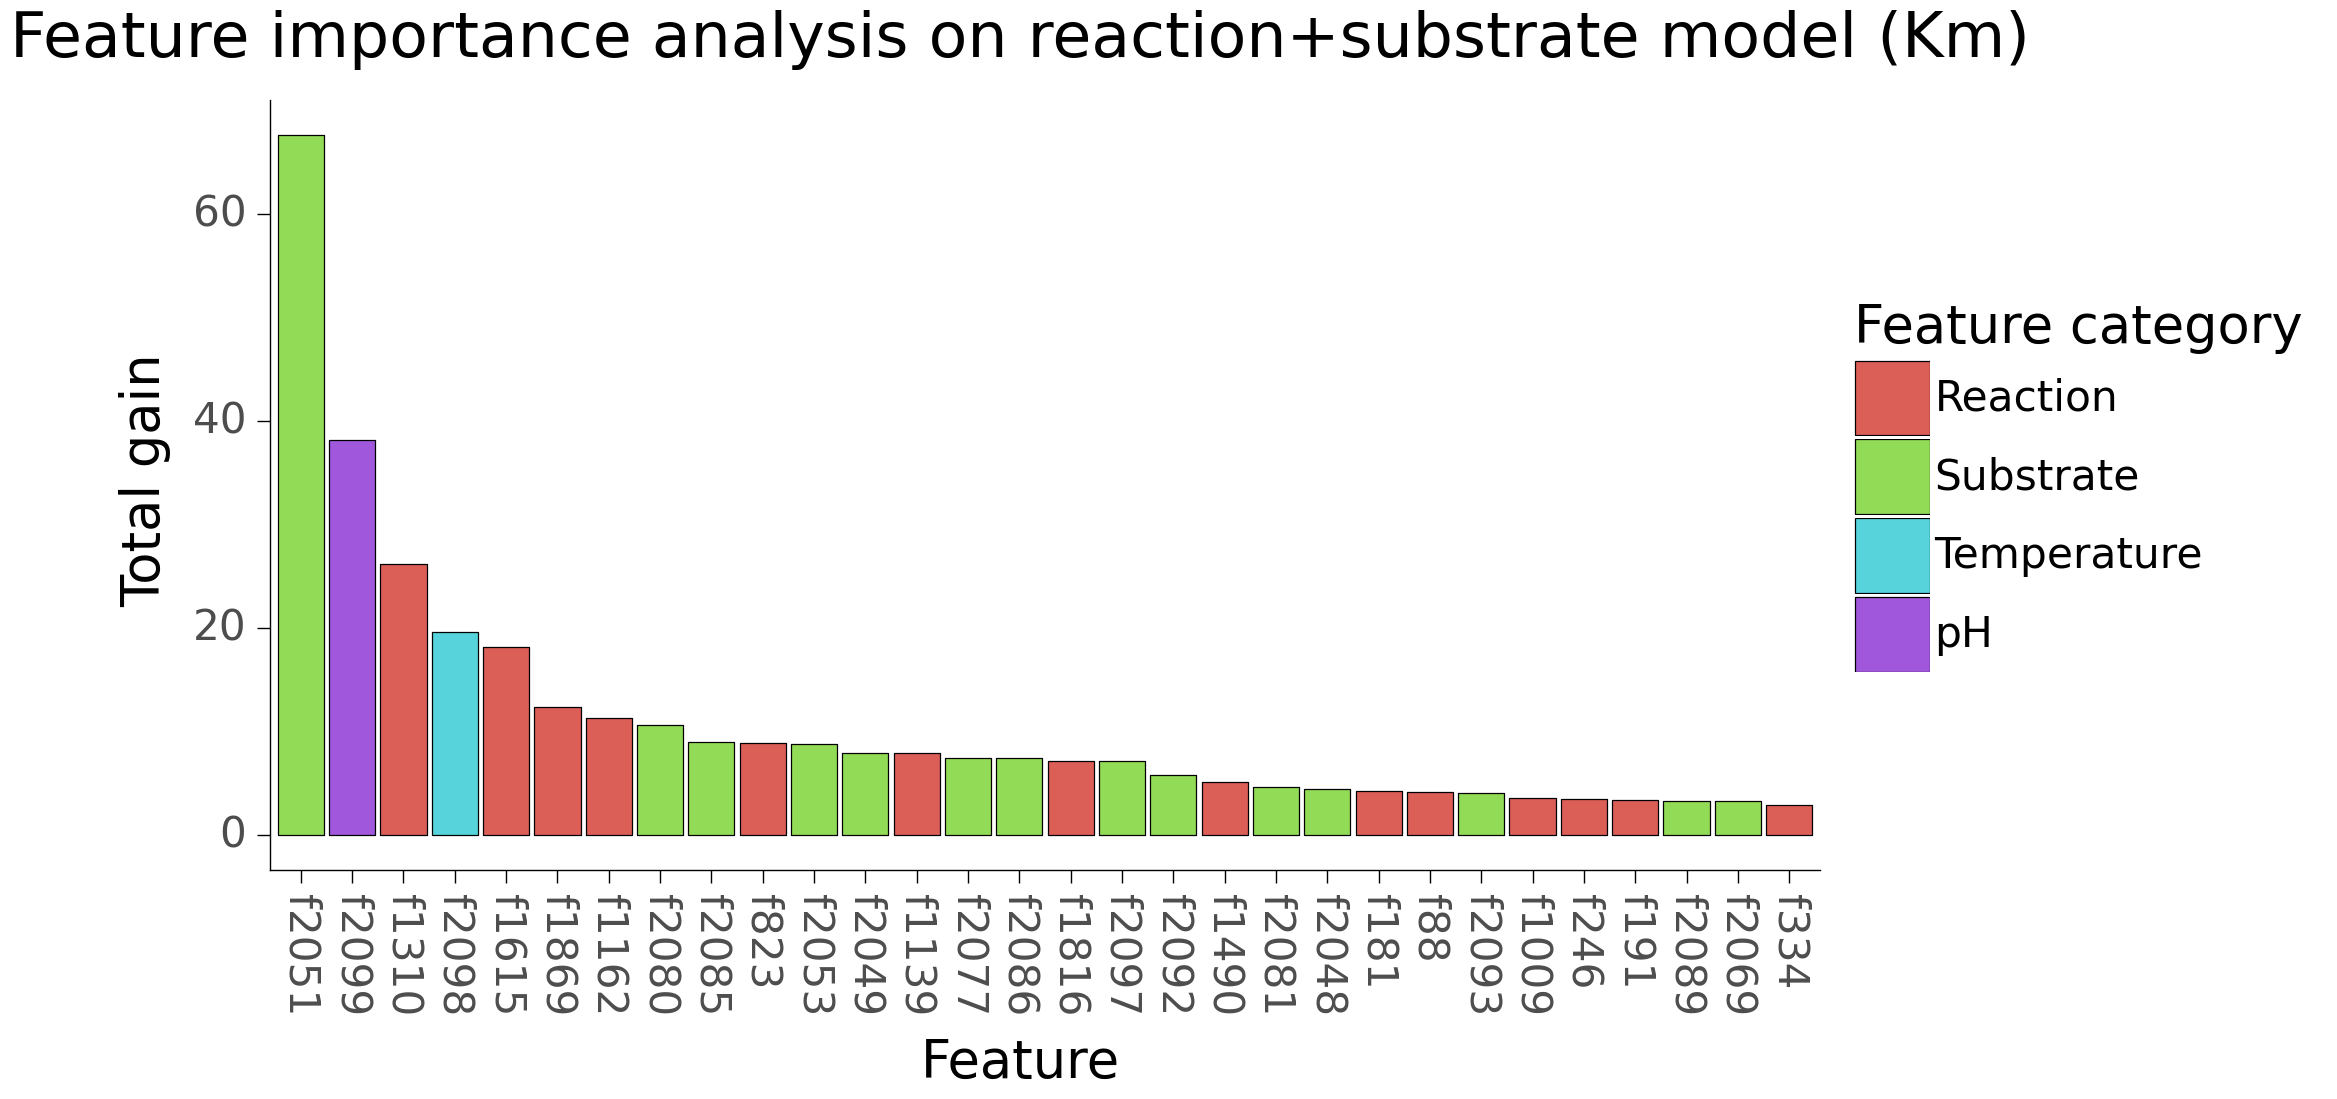

<ggplot: (-9223371914737751484)>

In [97]:
# plot
from plotnine import *
importances = bst.get_score(importance_type="total_gain")
# del(list)
list = list(importances.items())
# Step 2: Sort the list of tuples based on values in descending order and keep the top 20
sorted_items = sorted(list, key=lambda x: x[1], reverse=True)[:30]
print(sorted_items)
dicti = dict(sorted_items)
importances = pd.DataFrame({'Feature' : dicti.keys(), "Importance" : dicti.values()})
def condition(x):
    if int(x[1:]) <= 2047:
        return "Reaction"
    elif 2048 <= int(x[1:]) <= 2097:
        return "Substrate"
    elif int(x[1:]) == 2098:
        return 'Temperature'
    else : 
        return 'pH'
importances["Feature category"] = importances["Feature"].apply(condition)
importances_order = importances.sort_values(by='Importance', ascending=False)["Feature"]
(ggplot(importances, aes(x="Feature", y="Importance", fill="Feature category"))
+ geom_bar(stat="identity", width=0.9, color='black')
+ scale_x_discrete(limits= importances_order)
+ labs(title="Feature importance analysis on reaction+substrate model (Km)", y = "Total gain")
+ theme_classic(base_size=38)
+ theme(figure_size=(20, 10), axis_text_x=element_text(angle=-90), plot_title = element_text(ha = "center"))
)


In [98]:
del(list)

#### (e) Validating model:

In [99]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
# data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_val.npy"), val_Y)
np.save(join("..", "..", "data", split, "y_val_pred_xgboost_diff_fp_gnn_fp.npy"), y_val_pred)

(0.6818551493917264, 0.0006632871608159583) 0.0018432566972590853 0.12316334523915462 0.00072963039708445 0.00010633489999653051


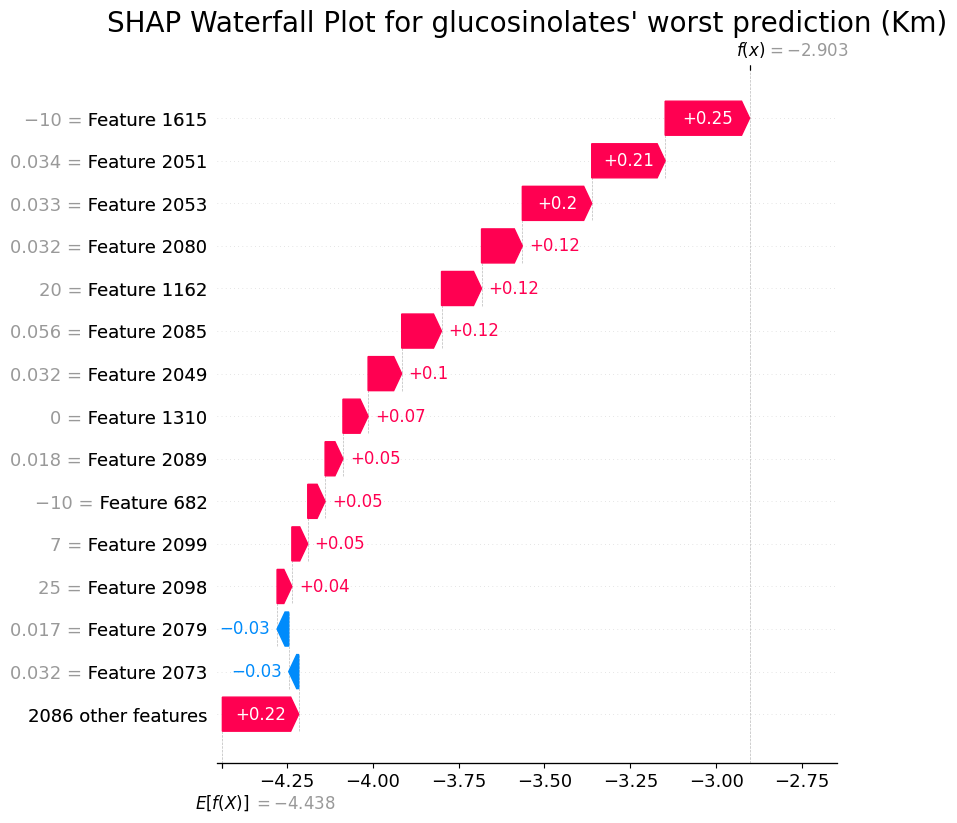

In [100]:
import shap
explainer = shap.TreeExplainer(bst)
explanation = explainer(val_X)

shap_values = explanation.values
# shap_interaction_values = explainer.shap_interaction_values(val_X)
# # make sure the SHAP values add up to marginal predictions
# np.abs(shap_values.sum(axis=1) + explanation.base_values - y_val_pred).max()
# # shap.plots.beeswarm(explanation)
# fig, ax = plt.subplots(1, 1, figsize=(10, 15))
# shap.decision_plot(explainer.expected_value, shap_values[19,20], highlight=[19,20])
# ax.set_title("SHAP Decision Plot for glucosinolates set (Km)")
# plt.show()

shap.plots.waterfall(explanation[19], max_display=15, show=False)
# Customize the title and font size
plt.title("SHAP Waterfall Plot for glucosinolates' worst prediction (Km)", fontsize=20)
plt.show()

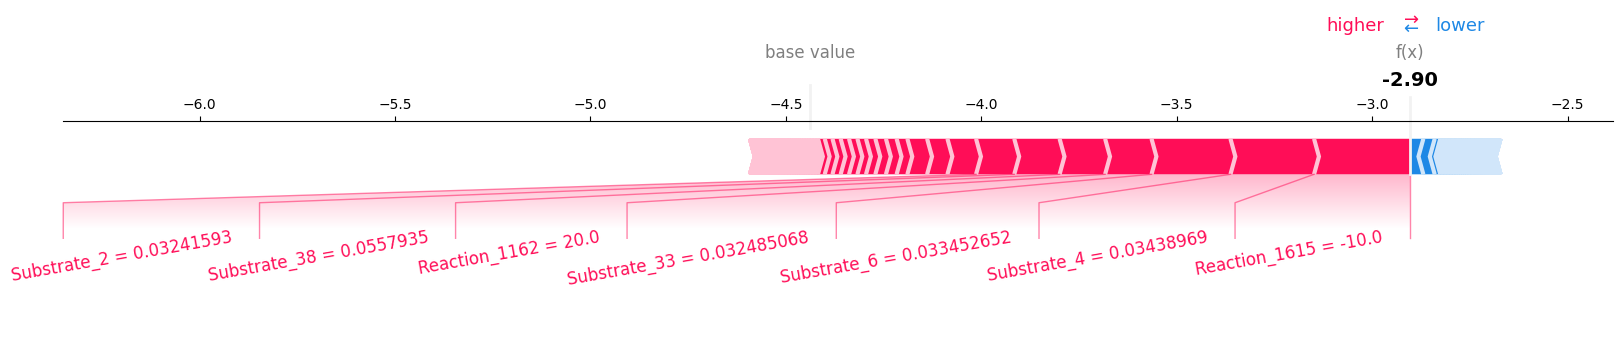

In [101]:
names = list()
for i in range(0, 2047):
    names.append("Reaction_%s" %str(i))

for i in range(0, 49):
    names.append("Substrate_%s" %str(i))

names.append(["Temperature", "pH"])

shap.force_plot(explainer.expected_value, shap_values[19], val_X[19], matplotlib=True, feature_names=names, text_rotation=10)

In [102]:
predictions = pd.DataFrame({"Actual Km": [10**x for x in val_Y], "Predicted Km" : [10**x for x in y_val_pred], "Difference" : abs(np.array([10**x for x in val_Y])-np.array([10**x for x in y_val_pred]))})

In [103]:
val_Y

array([-4.46852108, -4.43179828, -3.71219827, -3.66554625, -4.13076828,
       -4.58502665, -3.4271284 , -3.82390874, -5.52287875, -4.20760831,
       -3.58502665, -4.03621217, -2.79317412, -3.03325771, -4.34486157,
       -4.34678749, -3.61083392, -4.43179828, -2.79588002, -2.04095861,
       -2.56863624])

In [104]:
data_test[data_test["Main Substrate"] == data_val.iloc[19]["Main Substrate"]]

,ECs,Organism,Uniprot IDs,PMID,Type,Km,Temperature,pH,Substrates,Products,...,MACCS FP,min_Km_for_EC,frac_of_min_UID,frac_of_min_RID,frac_of_min_EC,GNN FP,Sequence ID_y,ESM2,log10_Km,Estimate Km


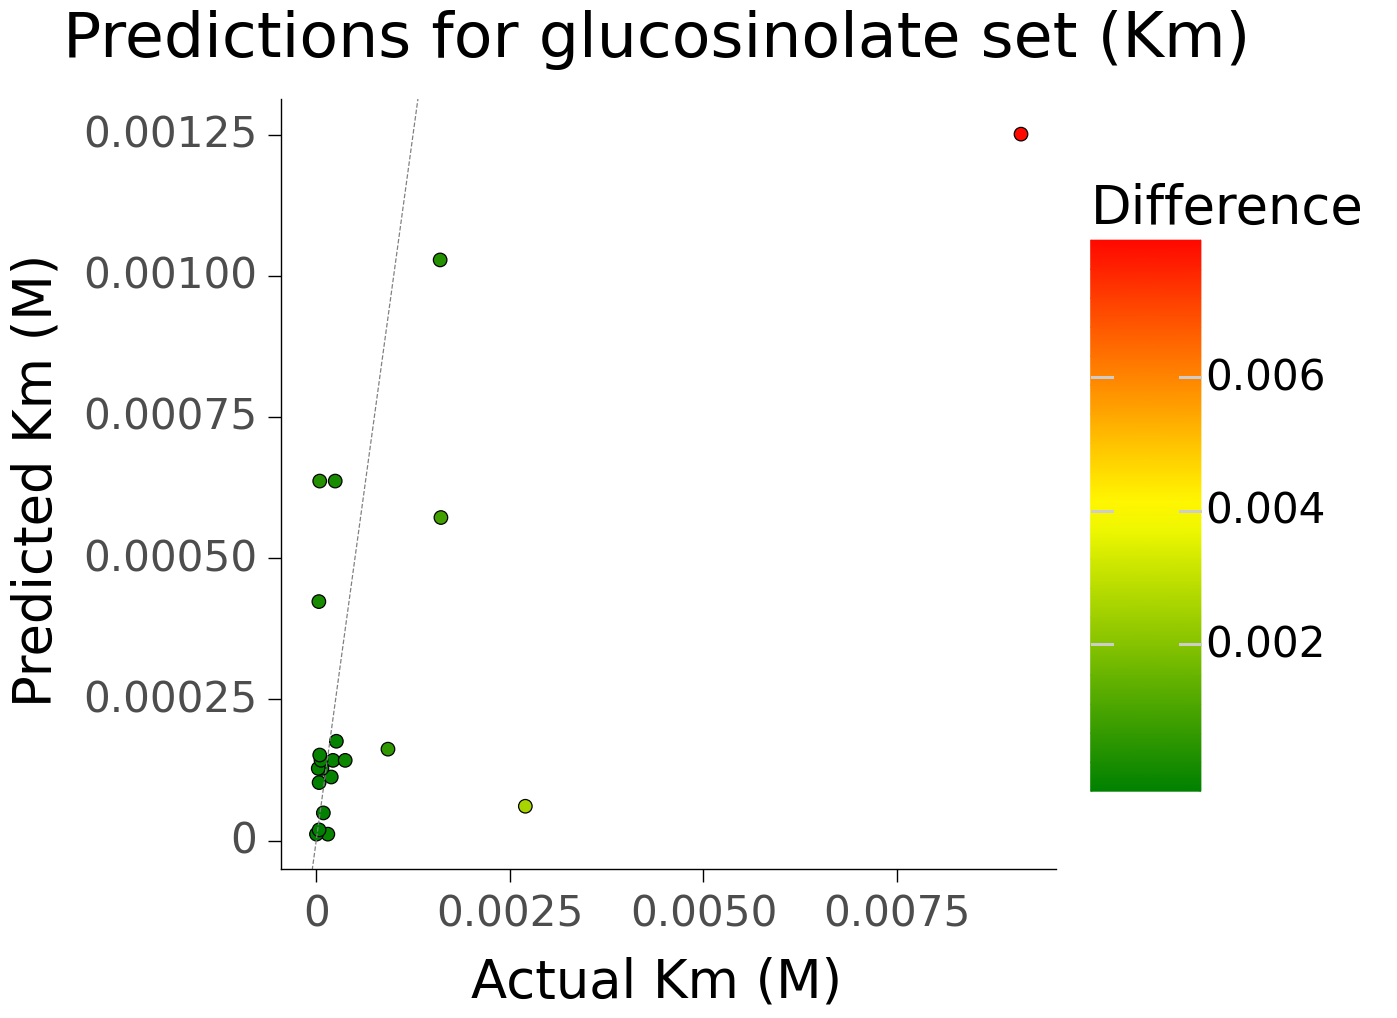

<ggplot: (-9223371914737651140)>

In [105]:
from plotnine import *

import textwrap

(
    ggplot(predictions, aes(x = "Actual Km", y="Predicted Km", fill="Difference"))
    + geom_point(color="black", size=5) 
    + geom_abline(slope = 1, intercept = 0, color = "grey", linetype="dashed")
    + scale_fill_gradient2(low = "green", mid="yellow", high = "red", midpoint=0.004)
    # + scale_x_discrete(labels= [textwrap.fill(label, width=10) for label in ["Enzyme","Enzyme+reaction", "Enzyme+substrate", "Enzyme+substrate+reaction", "Reaction", "Substrate", "Substrate+reaction"]])
    + labs(title="Predictions for glucosinolate set (Km)", x="Actual Km (M)", y="Predicted Km (M)", fill="Difference")
    + theme_classic(base_size=38)
    + xlim(min(predictions["Actual Km"]), max(predictions["Actual Km"]))
    + ylim(min(predictions["Predicted Km"]), max(predictions["Predicted Km"]))
    + theme(figure_size=(10, 10))
)


## Plots

In [106]:
results_test = pd.read_csv('../../data/Results_test.csv')

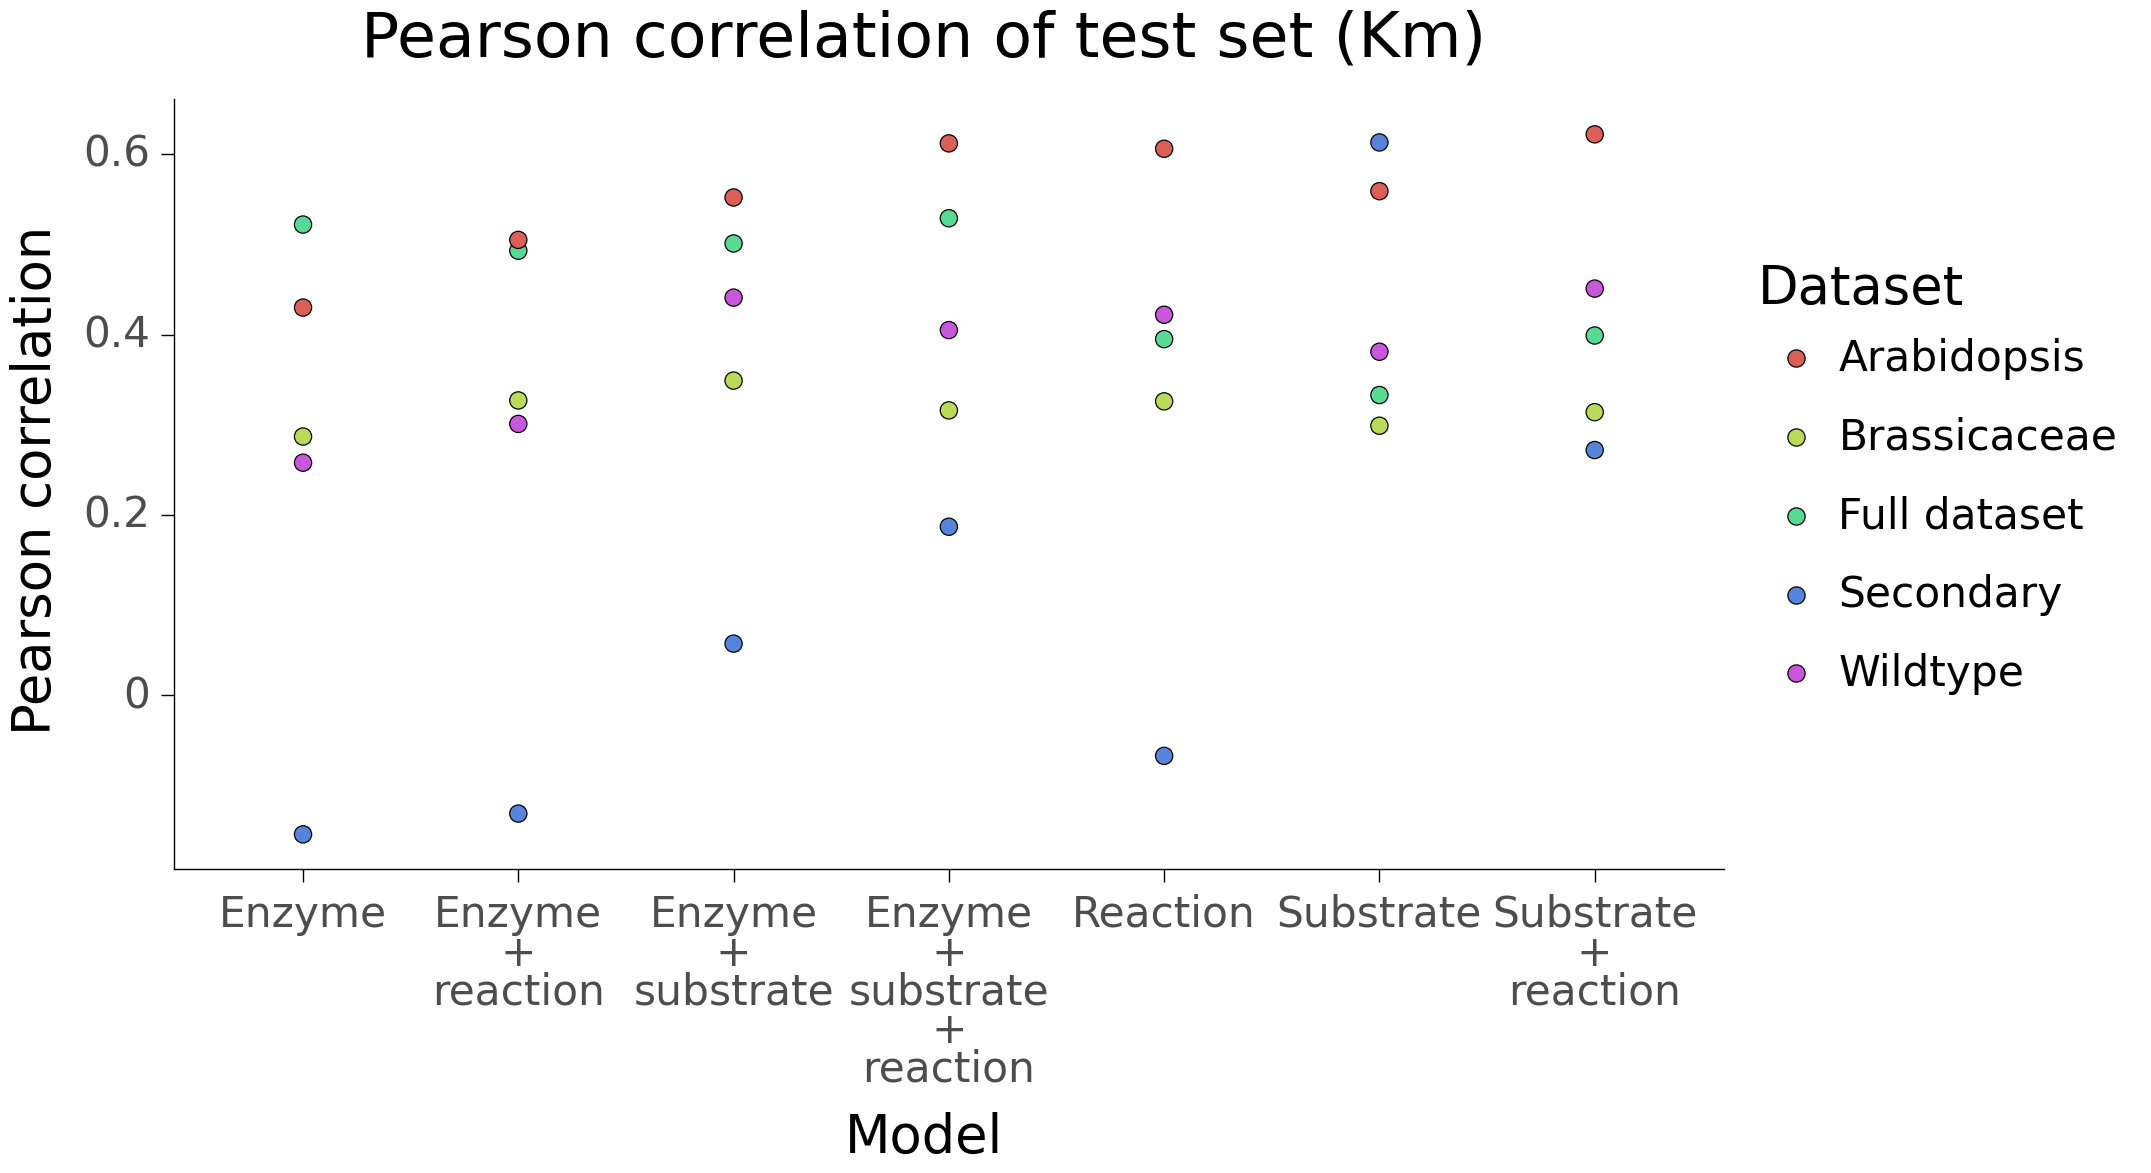

<ggplot: (-9223371914736386572)>

In [107]:
from plotnine import (
    ggplot,
    aes,
    geom_point,
    labs,
    theme_classic,
    theme,
    scale_x_discrete
)

import textwrap
(
    ggplot(results_test, aes(x = "Model", y="Pearson correlation"))
    + geom_point(aes(fill="Dataset"), size=6.5) 
    + scale_x_discrete(labels= ["Enzyme","Enzyme\n+\nreaction", "Enzyme\n+\nsubstrate", "Enzyme\n+\nsubstrate\n+\nreaction", "Reaction", "Substrate", "Substrate\n+\nreaction"])
    + labs(title="Pearson correlation of test set (Km)", x="Model", y="Pearson correlation", fill="Dataset")
    + theme_classic(base_size=38)
    + theme(figure_size=(20, 10))
)



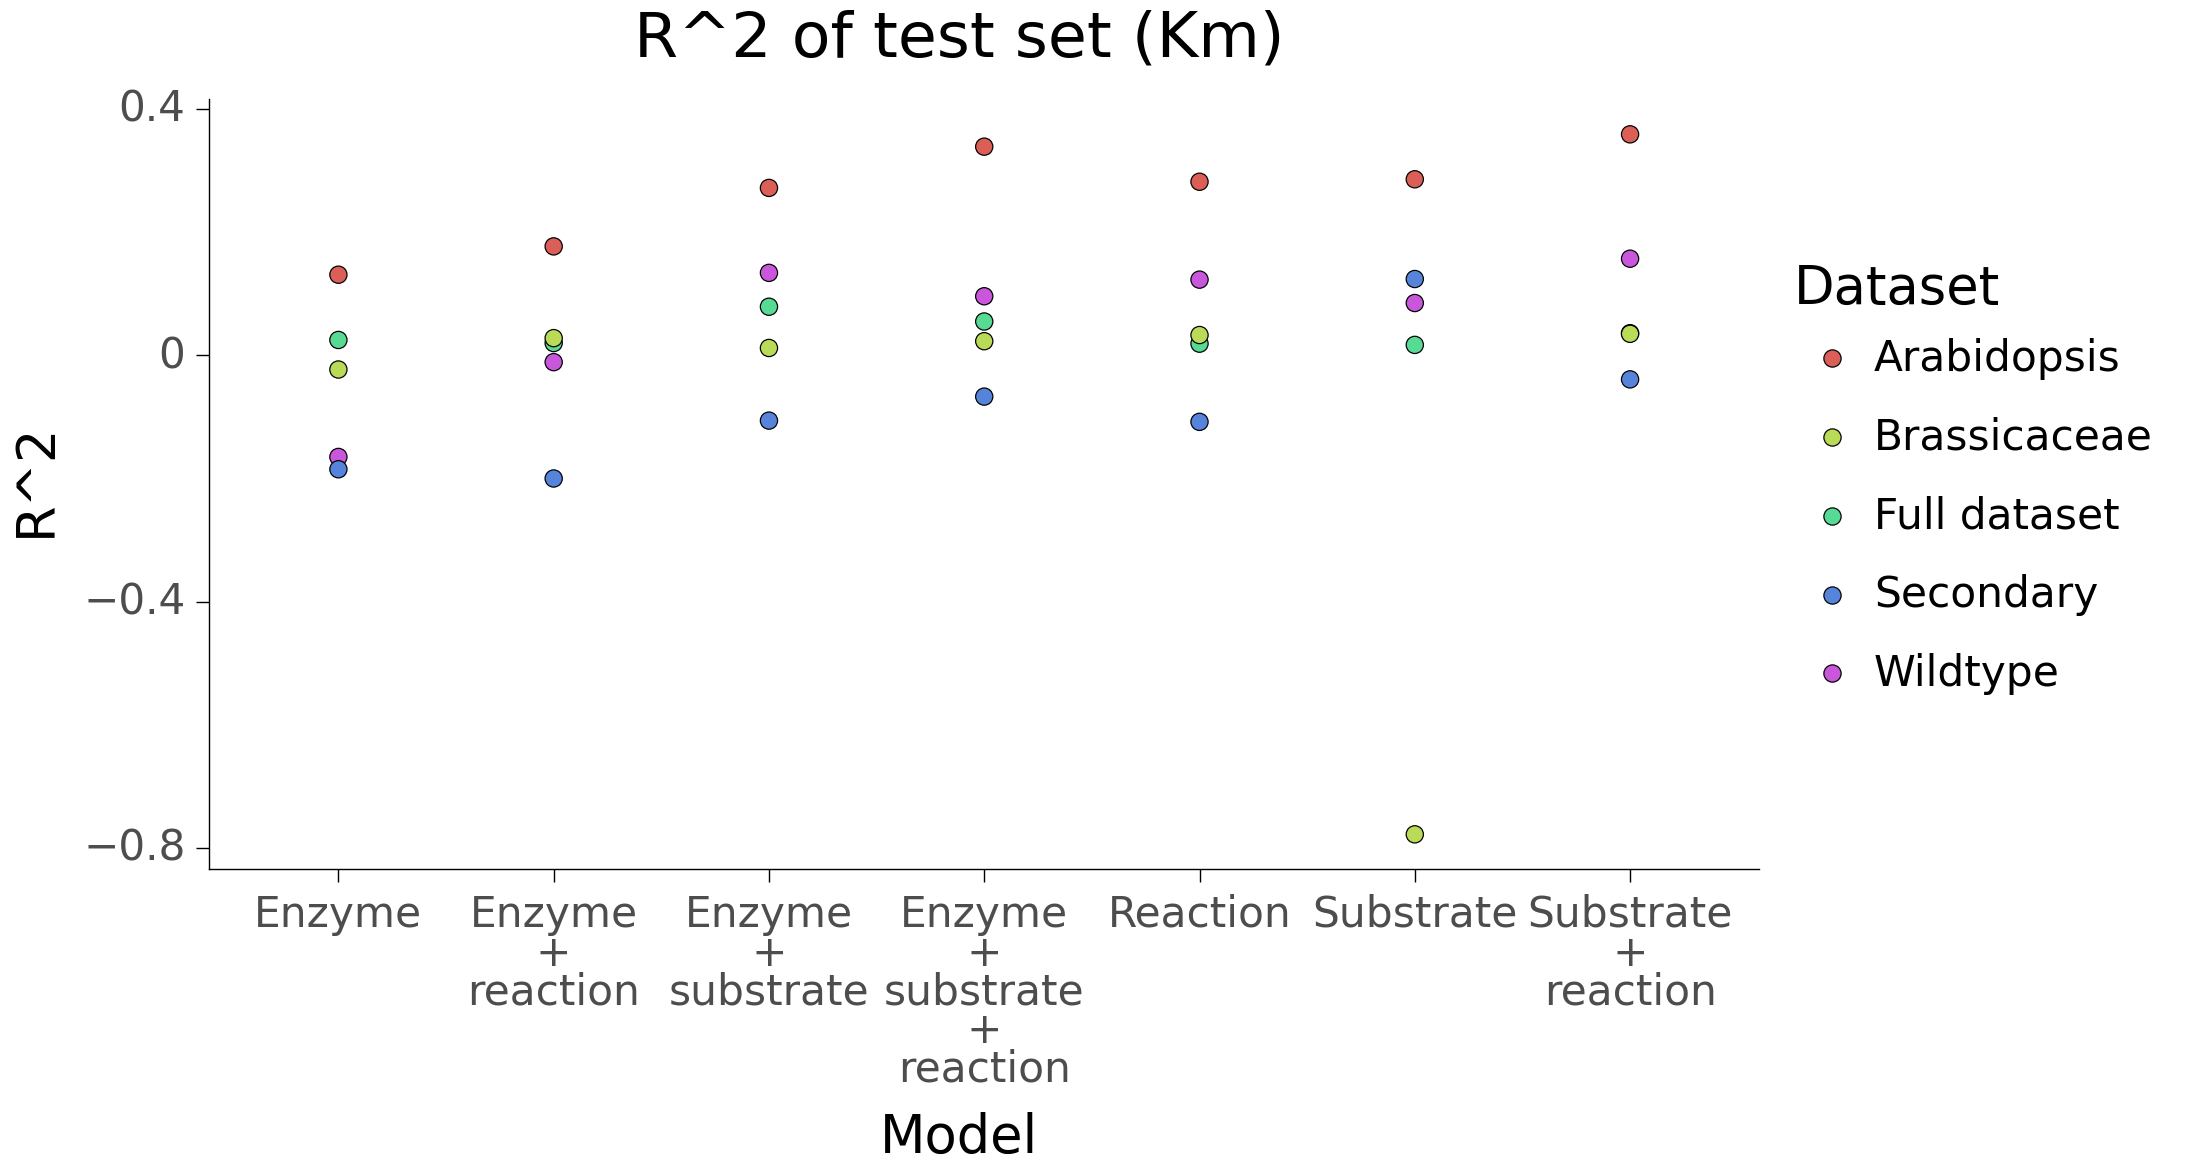

<ggplot: (-9223371914736391956)>

In [108]:
(
    ggplot(results_test, aes(x = "Model", y="R^2"))
    + geom_point(aes(fill="Dataset"), size=6.5) 
    + scale_x_discrete(labels= ["Enzyme","Enzyme\n+\nreaction", "Enzyme\n+\nsubstrate", "Enzyme\n+\nsubstrate\n+\nreaction", "Reaction", "Substrate", "Substrate\n+\nreaction"])
    + labs(title="R^2 of test set (Km)", x="Model", y="R^2", fill="Dataset")
    + theme_classic(base_size=38)
    + theme(figure_size=(20, 10))
)

In [109]:
results_val = pd.read_csv('../../data/Results_val.csv')

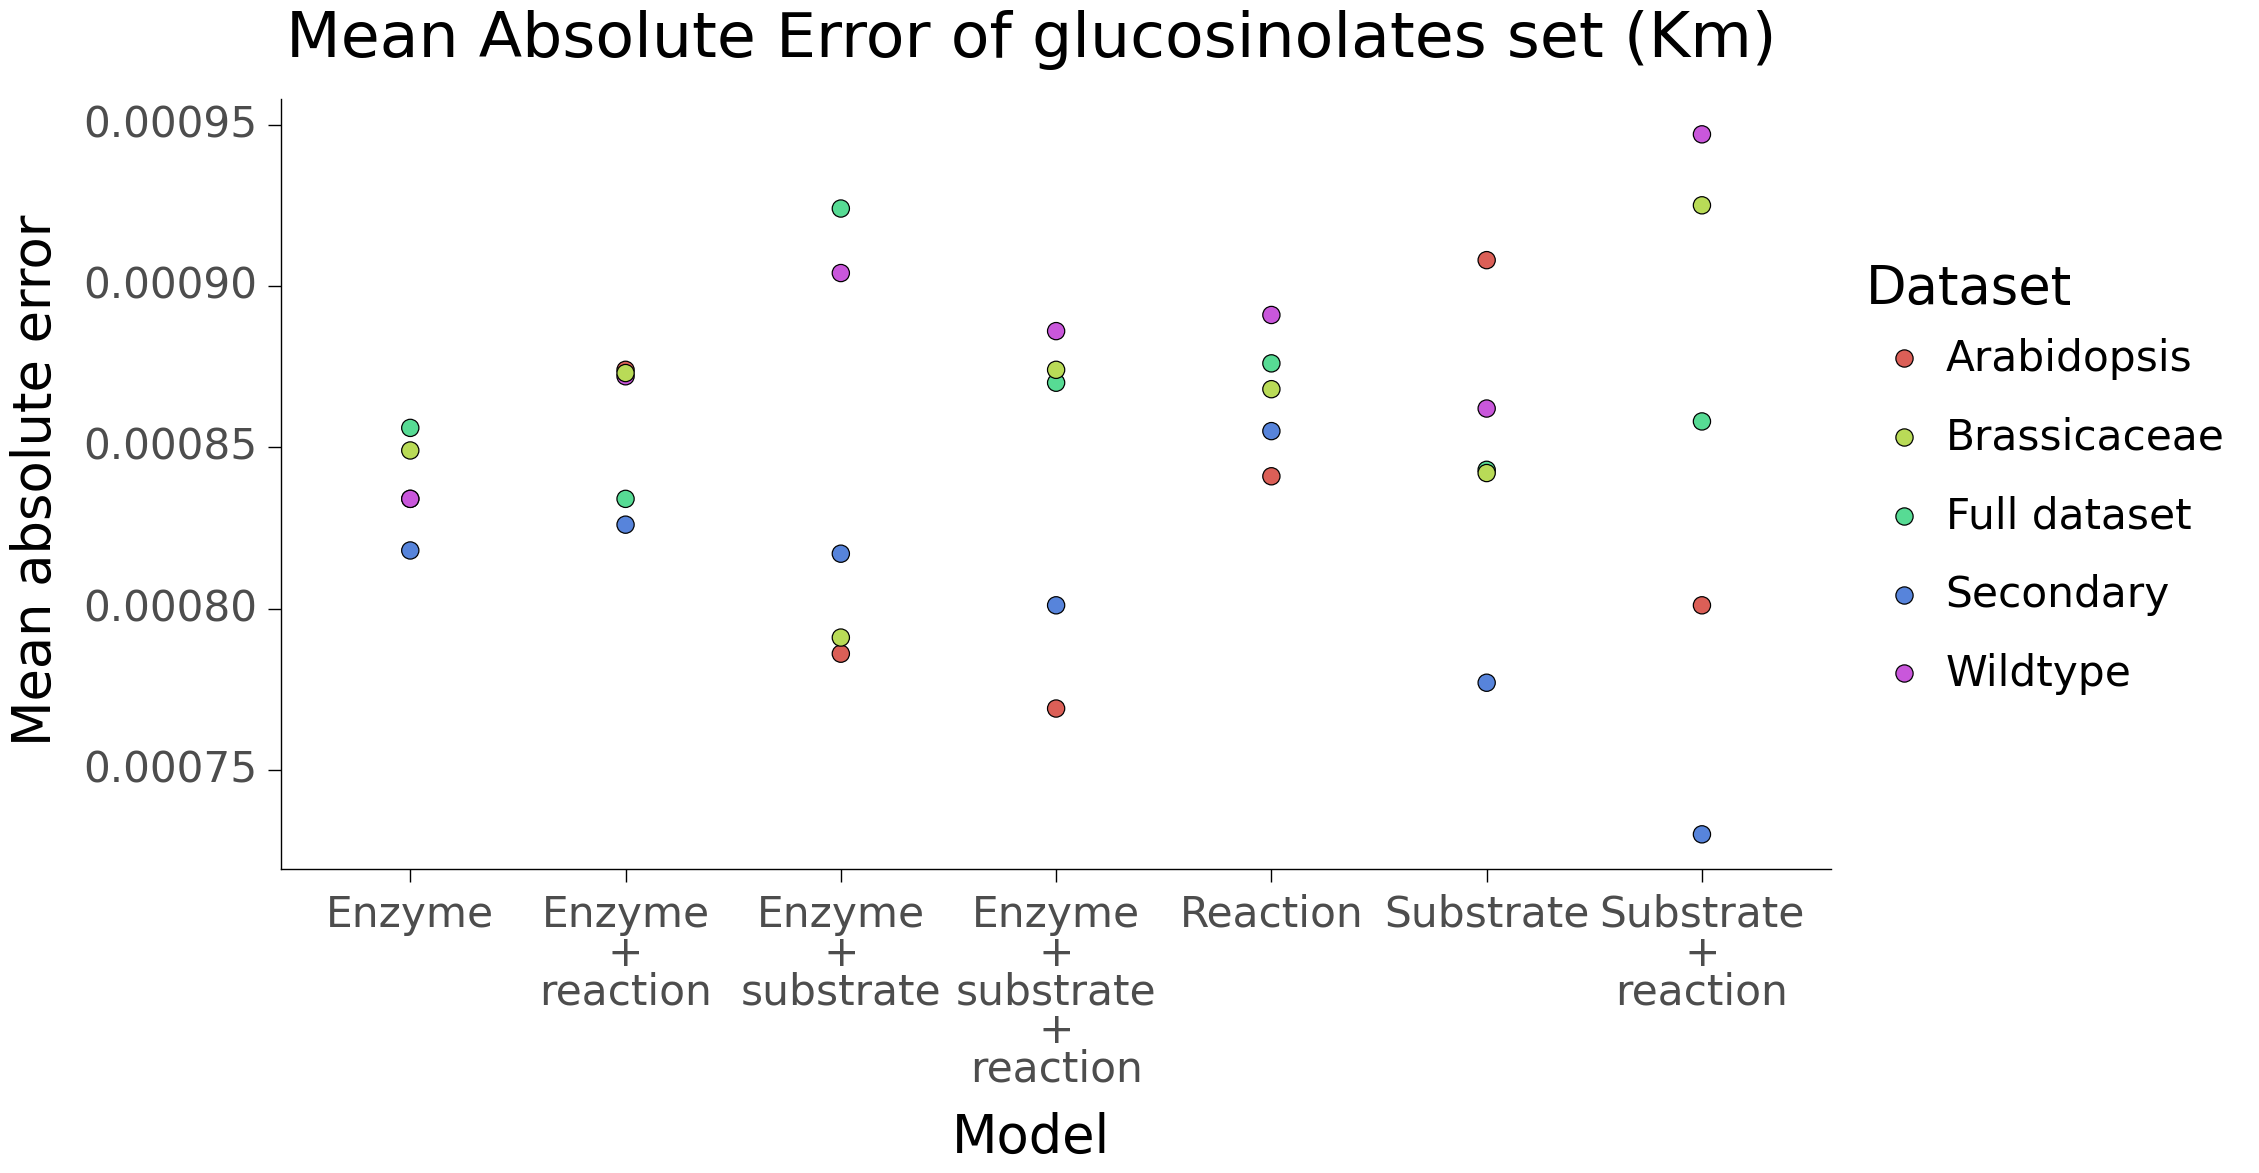

<ggplot: (-9223371914727990860)>

In [110]:
from plotnine import *

import textwrap

(
    ggplot(results_val, aes(x = "Model", y="MAE"))
    + geom_point(aes(fill="Dataset"), size=6.5) 
    + scale_x_discrete(labels= ["Enzyme","Enzyme\n+\nreaction", "Enzyme\n+\nsubstrate", "Enzyme\n+\nsubstrate\n+\nreaction", "Reaction", "Substrate", "Substrate\n+\nreaction"])
    + labs(title="Mean Absolute Error of glucosinolates set (Km)", x="Model", y="Mean absolute error", fill="Dataset")
    + theme_classic(base_size=38)
    # + position_dodge(width=1.0, preserve="total")
    + theme(figure_size=(20, 10))
)



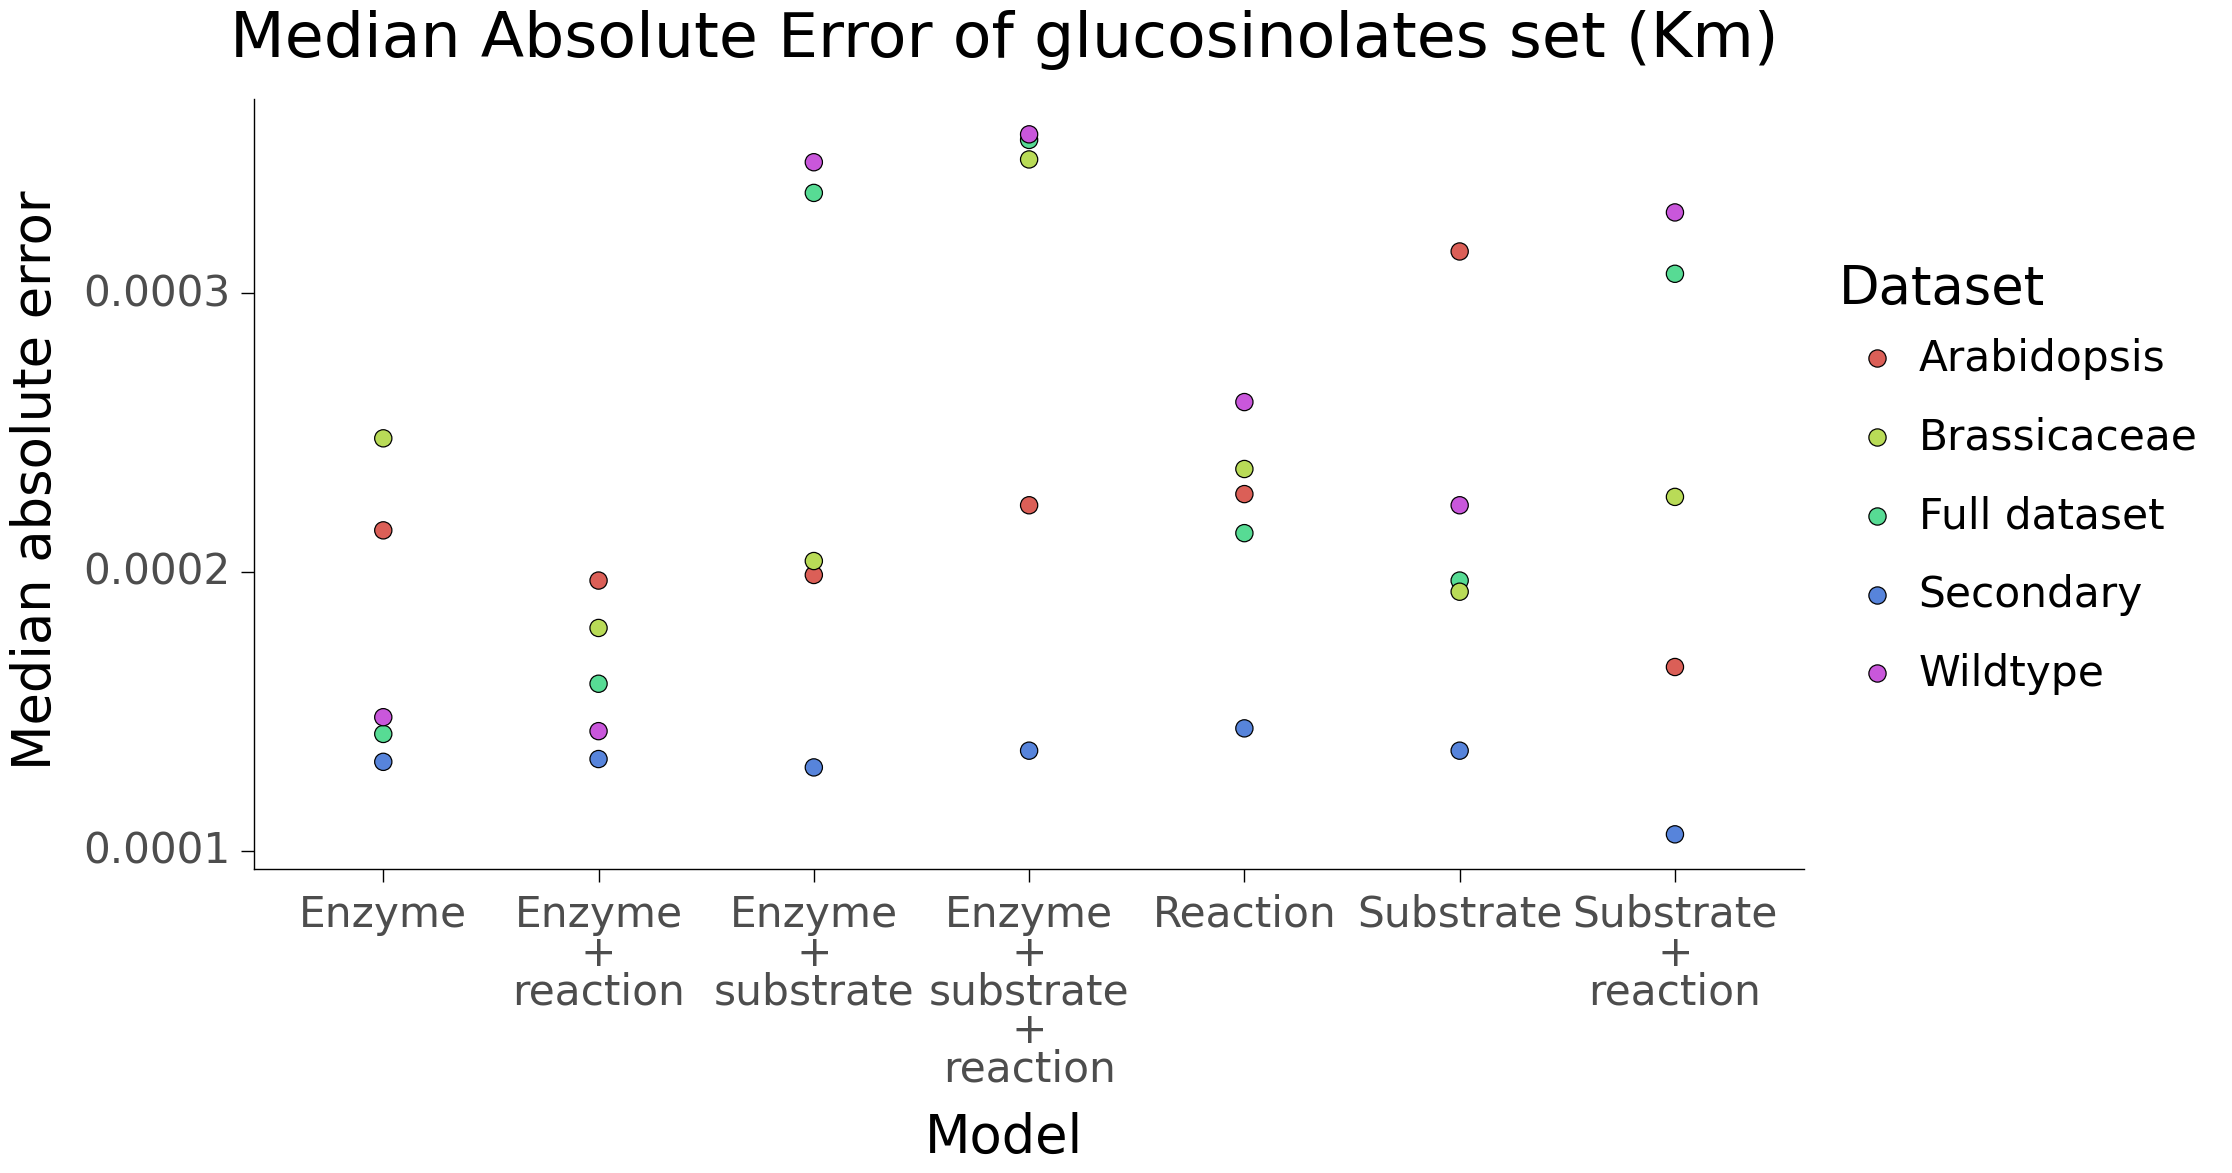

<ggplot: (-9223371914727940372)>

In [111]:
(
    ggplot(results_val, aes(x = "Model", y="MedAE"))
    + geom_point(aes(fill="Dataset"), size=6.5) 
    + scale_x_discrete(labels= ["Enzyme","Enzyme\n+\nreaction", "Enzyme\n+\nsubstrate", "Enzyme\n+\nsubstrate\n+\nreaction", "Reaction", "Substrate", "Substrate\n+\nreaction"])
    + labs(title="Median Absolute Error of glucosinolates set (Km)", x="Model", y="Median absolute error", fill="Dataset")
    + theme_classic(base_size=38)
    + theme(figure_size=(20, 10))
)